In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=20, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, sub_weight=0.5)

head params 3283
embs params 1430
train epoch 00/20 | batch 320/319 | loss 0.9784 | val loss 0.7435 | acc 0.0946 | f1 0.1728 | prec 0.0946 | recall 1.0000 | roc auc 0.5109 | pr auc 0.1130 | elapsed 10.06s
train epoch 01/20 | batch 320/319 | loss 0.6889 | val loss 0.1280 | acc 0.9614 | f1 0.7580 | prec 0.9306 | recall 0.6394 | roc auc 0.9292 | pr auc 0.8303 | elapsed 12.95s
train epoch 02/20 | batch 320/319 | loss 0.5899 | val loss 0.1191 | acc 0.9624 | f1 0.7673 | prec 0.9241 | recall 0.6560 | roc auc 0.9433 | pr auc 0.8463 | elapsed 11.47s
train epoch 03/20 | batch 320/319 | loss 0.5837 | val loss 0.1166 | acc 0.9625 | f1 0.7711 | prec 0.9110 | recall 0.6684 | roc auc 0.9480 | pr auc 0.8511 | elapsed 11.62s
train epoch 04/20 | batch 320/319 | loss 0.5803 | val loss 0.1145 | acc 0.9621 | f1 0.7749 | prec 0.8833 | recall 0.6902 | roc auc 0.9509 | pr auc 0.8551 | elapsed 10.80s
train epoch 05/20 | batch 320/319 | loss 0.5750 | val loss 0.1097 | acc 0.9638 | f1 0.7843 | prec 0.8995 | reca

In [21]:
sub_nn = reasoner.head.sub_nn
optimizer = T.optim.AdamW([sub_nn.parameters(), reasoner.top_concept], 0.0001)

for i in range(8000):
    optimizer.zero_grad()
    input1 = T.rand(10)

    loss = 1 - T.sigmoid(sub_nn(im_mod(input1,input1)))

    if i%5000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

reasoner.head.sub_nn = sub_nn

AttributeError: 'ModifiedNeuralReasoner' object has no attribute 'top_concept'

In [7]:
not_nn = reasoner.head.not_nn
top = reasoner.head.top_concept[0]
bot = reasoner.head.bot_concept[0]
optimizer = T.optim.AdamW(not_nn.parameters(), 0.0001)

for i in range(30000):
    optimizer.zero_grad()
    input1 = T.rand(10)

    loss = (F.mse_loss(input1, not_nn(not_nn(input1))))
    loss+=(F.mse_loss(top, not_nn(bot)))
    loss+=(F.mse_loss(bot, not_nn(top)))

    if i%5000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

reasoner.head.not_nn = not_nn


and_nn = reasoner.head.and_nn
bot = reasoner.head.bot_concept[0]
top = reasoner.head.top_concept[0]
not_nn = reasoner.head.not_nn
optimizer = T.optim.AdamW(and_nn.parameters(), 0.0001)

for i in range(50000):
    optimizer.zero_grad()
    input1 = T.rand(10)
    input2 = T.rand(10)
    input3 = T.rand(10)
    loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    loss += F.mse_loss(bot, and_nn(im_mod(bot, input1)))
    loss += F.mse_loss(input3, and_nn(im_mod(input3,top)))
    loss += F.mse_loss(bot, and_nn(im_mod(input2, not_nn(input2))))
    loss += F.mse_loss(and_nn(im_mod(input2,input1)) , and_nn(im_mod(input1,input2)))
    loss += F.mse_loss(and_nn(im_mod(input3,input2)) , and_nn(im_mod(input2,input3)))

    if i%10000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

reasoner.head.and_nn = and_nn

loss:  tensor(1.2222, grad_fn=<AddBackward0>)
loss:  tensor(0.0541, grad_fn=<AddBackward0>)
loss:  tensor(0.0389, grad_fn=<AddBackward0>)
loss:  tensor(0.0009, grad_fn=<AddBackward0>)
loss:  tensor(0.0001, grad_fn=<AddBackward0>)
loss:  tensor(2.4297e-09, grad_fn=<AddBackward0>)
loss:  tensor(1.8467, grad_fn=<AddBackward0>)
loss:  tensor(0.0165, grad_fn=<AddBackward0>)
loss:  tensor(0.0168, grad_fn=<AddBackward0>)
loss:  tensor(0.0065, grad_fn=<AddBackward0>)
loss:  tensor(0.0171, grad_fn=<AddBackward0>)


In [8]:
log = train_mod(data, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=10, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, and_nn_loss_weight=50, not_nn_loss_weight=100, top_bot_weight=18, train_top_bot=True, sub_weight=0.8)

train epoch 00/10 | batch 320/319 | loss 0.1072 | val loss 0.0136 | acc 0.9971 | f1 0.9846 | prec 0.9746 | recall 0.9948 | roc auc 0.9999 | pr auc 0.9993 | elapsed 7.17s
train epoch 01/10 | batch 320/319 | loss 0.4019 | val loss 0.0109 | acc 0.9967 | f1 0.9821 | prec 0.9989 | recall 0.9658 | roc auc 0.9999 | pr auc 0.9992 | elapsed 8.68s
train epoch 02/10 | batch 320/319 | loss 0.3951 | val loss 0.0075 | acc 0.9980 | f1 0.9896 | prec 0.9968 | recall 0.9824 | roc auc 1.0000 | pr auc 0.9997 | elapsed 8.71s
train epoch 03/10 | batch 320/319 | loss 0.3972 | val loss 0.0055 | acc 0.9994 | f1 0.9969 | prec 0.9990 | recall 0.9948 | roc auc 1.0000 | pr auc 0.9999 | elapsed 8.60s
train epoch 04/10 | batch 320/319 | loss 0.4286 | val loss 0.0045 | acc 0.9985 | f1 0.9922 | prec 1.0000 | recall 0.9845 | roc auc 1.0000 | pr auc 1.0000 | elapsed 8.61s
train epoch 05/10 | batch 320/319 | loss 0.4577 | val loss 0.0038 | acc 0.9996 | f1 0.9979 | prec 0.9979 | recall 0.9979 | roc auc 1.0000 | pr auc 1.0

         mean  std  micro
acc       1.0  NaN    1.0
prec      1.0  NaN    1.0
recall    1.0  NaN    1.0
f1        1.0  NaN    1.0
auc_roc   1.0  NaN    1.0
auc_pr    1.0  NaN    1.0


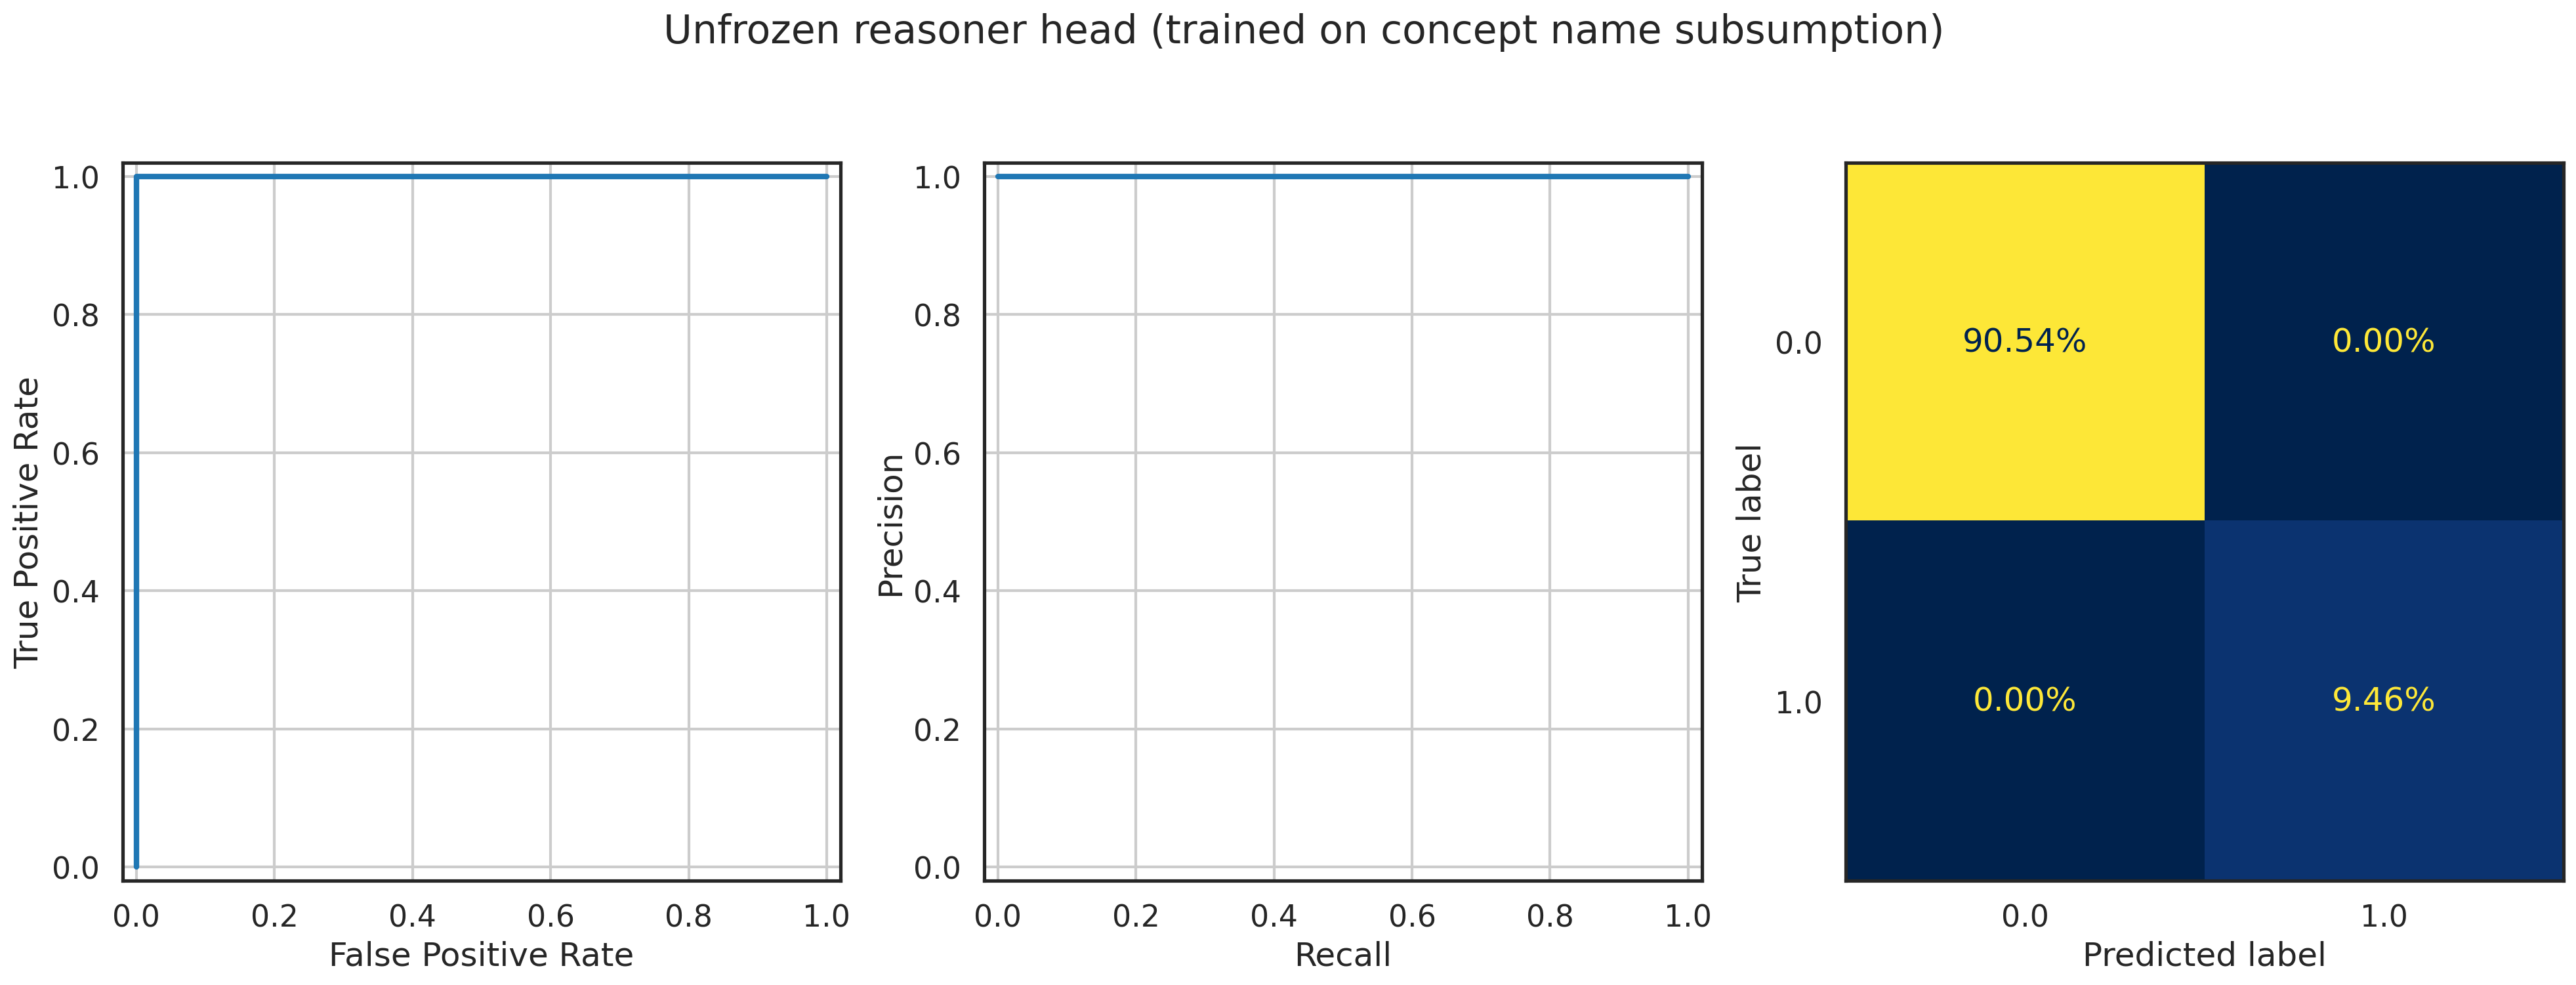

In [9]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [10]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.mse_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([0.2484, 0.8735, 0.6737, 0.5276, 0.0684, 0.1886, 0.9443, 0.3803, 0.3298,
        0.3990])
tensor([0.2142, 0.7705, 0.6816, 0.5627, 0.1002, 0.2487, 0.8126, 0.4030, 0.4010,
        0.3678], grad_fn=<AddBackward0>)


tensor(0.0042, grad_fn=<MseLossBackward0>)

In [11]:
input = T.rand(10)

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.mse_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([-1.0561, -0.3298,  0.5533,  0.0829, -0.0448,  0.0959, -0.9638,  0.6483,
         0.7486, -0.9024], grad_fn=<SelectBackward0>)
tensor([-0.9174, -0.3812,  0.4501,  0.1789,  0.0479,  0.1055, -0.8983,  0.6340,
         0.7317, -0.7294], grad_fn=<AddBackward0>)
tensor(0.0085, grad_fn=<MseLossBackward0>)


In [12]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.mse_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.1430, 0.5625, 0.8511, 0.7210, 0.7603, 0.2974, 0.7504, 0.7786, 0.2572,
        0.7332])


tensor([0.2822, 0.4136, 0.4246, 0.4164, 0.6236, 0.3104, 0.7016, 0.7835, 0.1759,
        0.5331], grad_fn=<AddBackward0>)
tensor(0.0384, grad_fn=<MseLossBackward0>)


In [13]:
input = T.rand(10)

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([-1.0561, -0.3298,  0.5533,  0.0829, -0.0448,  0.0959, -0.9638,  0.6483,
         0.7486, -0.9024], grad_fn=<SelectBackward0>)
tensor([-0.6348, -0.0416,  0.3294,  0.0201,  0.3434, -0.0264, -0.6800,  0.2718,
         0.4264, -0.5804], grad_fn=<AddBackward0>)
tensor(0.5859, grad_fn=<MseLossBackward0>)


In [14]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([-1.0561, -0.3298,  0.5533,  0.0829, -0.0448,  0.0959, -0.9638,  0.6483,
         0.7486, -0.9024], grad_fn=<SelectBackward0>)
tensor([-0.7295, -0.4170,  0.4180,  0.1433,  0.1654, -0.0208, -0.8052,  0.7574,
         0.9527, -0.5175], grad_fn=<SqueezeBackward3>)


tensor(0.0421, grad_fn=<MseLossBackward0>)


In [15]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([ 0.7029, -0.0051, -0.6551, -0.5607,  0.5580,  0.2656,  1.3671,  0.6924,
        -0.5878,  0.5491], grad_fn=<SelectBackward0>)
tensor([ 0.8363, -0.1364, -0.5392, -0.3430,  0.6263,  0.2849,  1.1276,  0.4280,
        -0.5516,  0.8567], grad_fn=<SqueezeBackward3>)
tensor(0.0324, grad_fn=<MseLossBackward0>)


In [16]:
input1 = T.rand(10)
input2 = T.rand(10)
print(and_nn(im_mod(input2,input1)))
print(and_nn(im_mod(input1,input2)))

F.mse_loss(and_nn(im_mod(input2,input1)) , and_nn(im_mod(input1,input2)))

tensor([0.3977, 0.2762, 0.4604, 0.9194, 0.2502, 0.4898, 0.7206, 0.1862, 0.5896,
        0.4403], grad_fn=<AddBackward0>)


tensor([0.4215, 0.3055, 0.4494, 0.9461, 0.2615, 0.4911, 0.7335, 0.1805, 0.6235,
        0.4726], grad_fn=<AddBackward0>)


tensor(0.0005, grad_fn=<MseLossBackward0>)

In [17]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te = np.array(Y_te)
y_te = np.array(y_te)
X_te = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te - y_te) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te[błędne_predykcje],
    'Predykcja': Y_te[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

   Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0     549                 0.0   0.403617          0         26         52
1    3513                 1.0   0.667356          0          4          4
2    4317                 1.0   0.587432          0          7          7
